# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *H*

**Names:**

* *BAFFOU Jérémy*
* *BASSETO Antoine*
* *PINTO Andrea*

---

#### Instructions

*This is a template for part 1 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import networkx as nx
import pandas as pd
import os 

---

## 2.1 Exploration of real networks

#### Exercise 2.1

We first load the graph into a pandas DataFrame. We try two possible representation (i.e. DataFrame) :  
- In the first case, the indexes give a node and the corresponding values give the other node at which it is attached
- In the other case, the index is the id of an edge and the value is a string where both edges are represented 

We called them network1 and network1_bis respectively

In [100]:
network_1 = pd.read_csv("/home/jeremy/EPFL/Internet_Analytics/ix-lab2/data/network1.csv", skiprows=1)

In [101]:
network_1bis = pd.read_csv("/home/jeremy/EPFL/Internet_Analytics/ix-lab2/data/network1.csv",sep='\t', skiprows=1)

In [102]:
network_1.head()

,# FromNodeId ToNodeId
0,11932
1,5128
2,7008
3,10476
4,9671


In [103]:
network_1bis.head()

,# FromNodeId ToNodeId
0,"0,11932"
1,"1,5128"
2,"2,7008"
3,"3,10476"
4,"4,9671"


In [104]:
print(f"The network is composed of {network_1.shape[0]} rows and {network_1.shape[1]} columns.")

The network is composed of 18584 rows and 1 columns.


In [105]:
network_1bis.describe()

,# FromNodeId ToNodeId
count,18584
unique,18584
top,"1064,7698"
freq,1


It doesn't seem to have duplicate edges as there is only unique rows. Nevertheless we have to be carefull that an edge isn't entered twice in its two possible form : (a,b) and (b,a).

We begin by renaming the column as the initial name is pretty complicated

In [106]:
network_1.rename(columns={'# FromNodeId ToNodeId' : 'Neighbours'}, inplace=True)
network_1bis.rename(columns={'# FromNodeId ToNodeId' : 'Edges'}, inplace=True)

In [107]:
print(network_1.columns)
print(network_1bis.columns)

Index(['Neighbours'], dtype='object')
Index(['Edges'], dtype='object')


We can now check for duplicates. For example the node 12734 has 4 neighbours : 

In [136]:
network_1["Neighbours"][12734]

12734    12971
12734    12859
12734    12766
12734    12789
Name: Neighbours, dtype: int64

But if we try to access we quickly see that we have a key error so no neighbours are in the index, thus there is no duplicates!

Now we will check the number of nodes and edges in this network. We first begin by creating a list of all the edges in the network:

In [159]:
edges_list = create_edges_list(network_1)
print(f"There is {len(edges_list)} in this network")

There is 18584 in this network


The value is consistent with what we had with the representation network_1bis. Now we create a graph using the package Networkx which allows easier and faster computations/manipulations on graph:

In [153]:
G1 = nx.Graph()
G1.add_edges_from(edges_list)

We can now check the number of nodes:

In [160]:
print(f"There is {len(list(G1.nodes))} nodes in the network")

There is 13033 nodes in the network


In [161]:
"""
create_edges_list(network):

Take as input a pandas DataFrame wich is the network. It will iteratively go through each edges and add it to
the growing list of edges.
"""
def create_edges_list(network):
    indexes = network.index.drop_duplicates()
    neighbours = network["Neighbours"]
    edges_list = []
    for i in indexes:
        nodes = neighbours[i]
        if type(nodes) == pd.core.series.Series: # we have to be carefull as sometimes there is multiple neighbours 
            for j in nodes.values:               # represented in a pandas Series.
                edges_list.append((i,j))
        else:
            edges_list.append((i,nodes))
    return edges_list

#### Exercise 2.2:  Node degree distribution

To plot the node degree distribution, a usefull plot would be a histogram which is the most frequently used type of graph when we want to plot discrete distributions.

In [167]:
degrees_list = [degree for node, degree in G1.degree] 

/home/jeremy/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Degree Distribution'}, ylabel='count'>

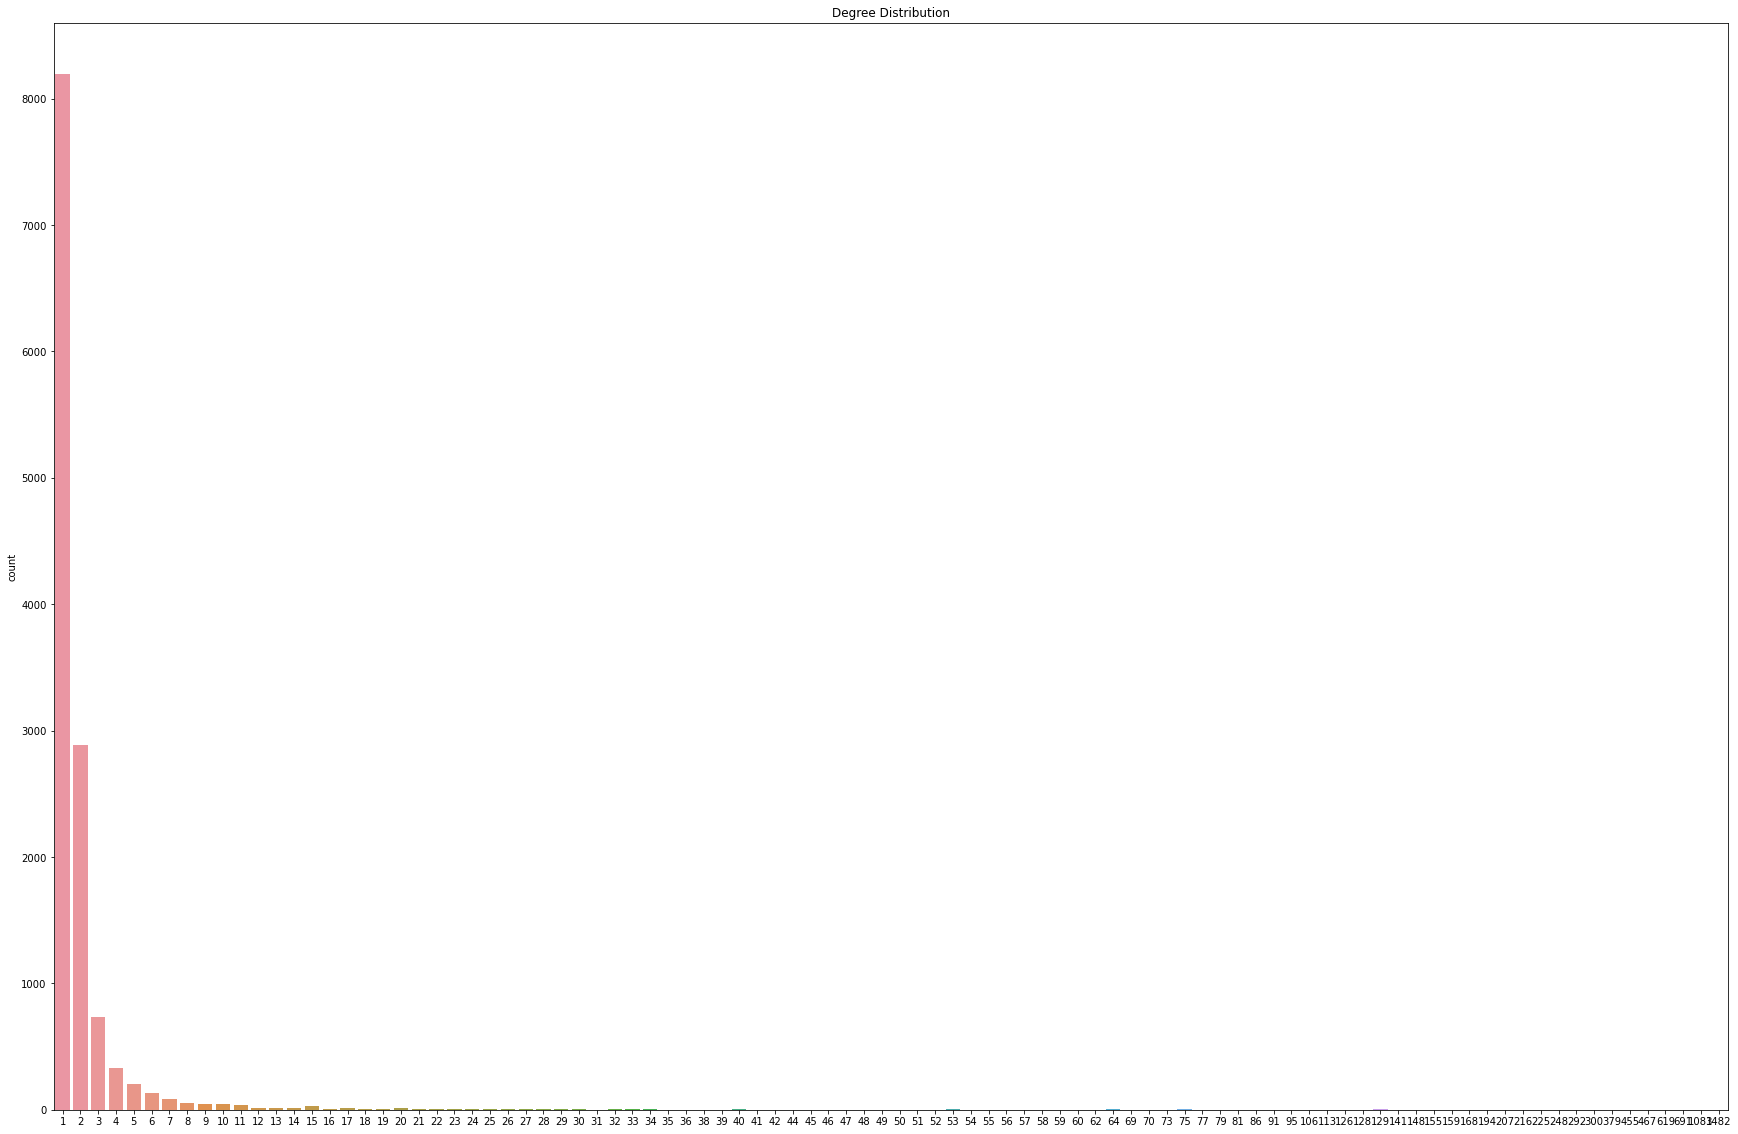

In [223]:
degree_series = pd.Series(degrees_list)
fig, ax = plt.subplots(figsize=(30,20))
ax.set_title("Degree Distribution")
sns.countplot(degree_series,ax=ax)

In [213]:
degrees_array = np.asarray(degrees_list)
print(f"The degree distribution seems to follow a distribution with mean : {degrees_array.mean()} and variance : {degrees_array.std()*degrees_array.std()}")

The degree distribution seems to follow a distribution with mean : 2.8518376429064682 and variance : 435.1334994620157


Là je sais pas trop pour la distribution, ça ressemble a du poisson mais trop d outsider (i.e. high variance). Ducoup peut être une power law genre pareto (mais discret).

#### Exercise 2.3: Giant component

Let's begin by listing all the connected components of our network using the package Networkx and its function `nx.connected_components()` : 

In [221]:
connected_components = list(nx.connected_components(G1))

Now we can check the number of components:

In [222]:
print(f"There is {len(connected_components)} components in the network 1")

There is 192 components in the network 1


Note that we could have directly used the function `number_connected_components()` from the same package.

Now let's see if there is a giant components. Let's recall that a giant component has two property :

- It is much larger than the other connected components
- It contains a significant fraction of the network

We will begin by sorting the connected components by increasing size (i.e. number of nodes they contain):

In [239]:
sorted_cc = sorted(connected_components, key=len)

In [247]:
print(f"The largest component has {len(sorted_cc[-1])} nodes and the second largest has {len(sorted_cc[-2])} nodes")
print(f"Furthermore the largest component contains {len(sorted_cc[-1])*100/len(list(G1.nodes))}% of the nodes, thus it is a Giant Component!")

The largest component has 12576 nodes and the second largest has 16 nodes
Furthermore the largest component contains 96.49351645822144% of the nodes, thus it is a Giant Component!


#### Exercise 2.4: Short paths & Small-worlds

#### Exercise 2.5: Network comparison

#### Exercise 2.6: Network identification